# ShapRFECV - Recursive Feature Elimination using SHAP importance

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ing-bank/probatus/blob/master/docs/tutorials/nb_shap_feature_elimination.ipynb)

Recursive Feature Elimination allows you to efficiently reduce the number of features in your dataset, without losing the predictive power of the model. `probatus` implements the following feature elimination routine for **tree-based & linear models**:


    While any features left, iterate:
        1. (Optional) Tune hyperparameters, in case sklearn compatible search CV e.g. `GridSearchCV` or
            `RandomizedSearchCV` or `BayesSearchCV`are passed as clf,
        2. Calculate SHAP feature importance using Cross-Validation,
        3. Remove `step` lowest importance features.


The functionality is similar to [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html), yet it removes the lowest importance features, based on SHAP features importance. It also supports the use of any hyperparameter search schema that is consistent with sklearn API e.g. [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) and [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV) passed as a `clf`, thanks to which you can perform hyperparameter optimization at each step of the search.
hyperparameters of the model at each round, to tune the model for each features set. Lastly, it supports categorical features (`object` and `category` dtype) and missing values in the data, as long as the model supports them.
 
The main advantages of using this routine are:

- It uses a tree-based or a linear model to detect the complex relations between features and the target.
- It uses SHAP importance, which is one of the most reliable ways to estimate features importance. Unlike many other techniques, it works with missing values and categorical variables.
- Supports the use of sklearn compatible hyperparameter search schemas e.g. [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) and [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV), in order to optimize hyperparameters at each iteration. This way you can assess if the removal of a given feature reduces the predictive power, or simply requires additional tuning of the model.
- You can also provide a list of features that should not be eliminated e.g. incase of prior knowledge.

The disadvantages are:

- Removing lowest [SHAP](https://shap.readthedocs.io/en/latest/) importance feature does not always translate to choosing the feature with the lowest impact on a model's performance. Shap importance illustrates how strongly a given feature affects the output of the model, while disregarding correctness of this prediction.
- Currently, the functionality only supports tree-based & linear binary classifiers, in the future the scope might be extended.
- For large datasets, performing hyperparameter optimization can be very computationally expensive. For gradient boosted tree models, one alternative is to use early stopping of the training step. For this, see [EarlyStoppingShapRFECV](#EarlyStoppingShapRFECV)

## Setup the dataset

In order to use the functionality, let's set up an example dataset with:

- 18 numerical features
- 1 static feature
- 1 static feature
- 1 feature with missing values

In [1]:
%%capture
!pip install probatus
!pip install lightgbm

In [1]:
from probatus.feature_elimination import ShapRFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import lightgbm
from sklearn.model_selection import RandomizedSearchCV
 
feature_names = ['f1', 'f2_missing', 'f3_static', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20']
 
# Prepare two samples
X, y = make_classification(n_samples=1000, class_sep=0.05, n_informative=6, n_features=20,
                           random_state=0, n_redundant=10, n_clusters_per_class=1)
X = pd.DataFrame(X, columns=feature_names)

X['f2_missing'] = X['f2_missing'].apply(lambda x: x if np.random.rand()<0.8 else np.nan)
X['f3_static'] = 0

In [2]:
#First 5 rows of first 5 columns
X[feature_names[:5]].head()

,f1,f2_missing,f3_static,f4,f5
0,3.399287,-3.902230,0,0.037207,-0.211075
1,-2.480698,0.772855,0,0.302824,0.729950
2,-0.690014,1.350847,0,1.837895,-0.745689
3,-5.291164,4.559465,0,-1.277930,3.688404
4,-1.028435,1.505766,0,-0.576209,-0.790525


## Set up the model and model tuning

You need to set up the model that you would like to use in the feature elimination. `probatus` requires a **tree-based or linear binary classifier** in order to speed up the computation of SHAP feature importance at each step. 
We recommend using [LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html), which by default handles missing values and categorical features.

The example below applies randomized search in order to optimize the hyperparameters of the model at each iteration of the search.

In [3]:
clf = lightgbm.LGBMClassifier(max_depth=5, class_weight='balanced')

param_grid = {
    'n_estimators': [5, 7, 10],
    'num_leaves': [3, 5, 7, 10],
}
search = RandomizedSearchCV(clf, param_grid)


## Apply ShapRFECV

Now let's apply the [ShapRFECV](https://ing-bank.github.io/probatus/api/feature_elimination.html).

In [4]:
shap_elimination = ShapRFECV(
    clf=search, step=0.2, cv=10, scoring='roc_auc', n_jobs=3)
report = shap_elimination.fit_compute(X, y)

At the end of the process, you can investigate the results for each iteration.

In [5]:
#First 5 rows of first 5 columns
report[['num_features', 'features_set', 'val_metric_mean']]

,num_features,features_set,val_metric_mean
1,20,"[f1, f2_missing, f3_static, f4, f5, f6, f7, f8...",0.922
2,16,"[f17, f19, f20, f8, f1, f9, f4, f18, f16, f14,...",0.922
3,13,"[f20, f19, f8, f1, f9, f18, f16, f14, f11, f5,...",0.923
4,11,"[f18, f20, f19, f16, f8, f14, f11, f5, f9, f10...",0.923
5,9,"[f20, f19, f16, f8, f14, f11, f5, f9, f15]",0.904
6,8,"[f20, f19, f16, f8, f14, f5, f9, f15]",0.910
7,7,"[f20, f19, f16, f8, f14, f9, f15]",0.905
8,6,"[f20, f19, f16, f14, f9, f15]",0.917
9,5,"[f19, f16, f14, f9, f15]",0.889
10,4,"[f19, f9, f16, f14]",0.877


###### Once the process is completed, you can visualize the results. 

Let's investigate the performance plot. In this case, the Validation AUC score has the highest Validation AUC at 11 features and a peak at 6 features.

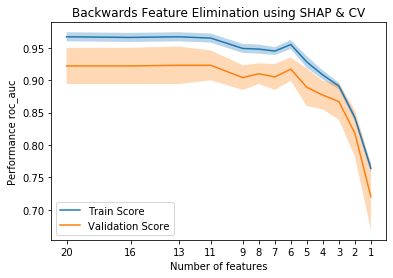

In [11]:
performance_plot = shap_elimination.plot()

Let's see the final feature set:

In [10]:
shap_elimination.get_reduced_features_set(num_features=6)

['f20', 'f19', 'f16', 'f14', 'f9', 'f15']

You can also provide a list of features that should not be eliminated. 
Say based on your prior knowledge you know that the features `f10,f19,f15` are important and should not be eliminated. This can be done by providing a list of columns to `columns_to_keep` parameter in the `fit()` function.


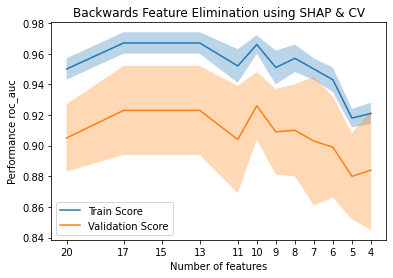

In [9]:
shap_elimination = ShapRFECV(
    clf=search, step=0.2, cv=10, scoring='roc_auc', n_jobs=3  ,min_features_to_select=4)
report = shap_elimination.fit_compute(X, y, columns_to_keep=['f10','f15','f19'])

performance_plot = shap_elimination.plot()


Let's see the final feature set:

In [10]:
shap_elimination.get_reduced_features_set(num_features=4)

['f15', 'f16', 'f10', 'f19']

## EarlyStoppingShapRFECV

[Early stopping](https://en.wikipedia.org/wiki/Early_stopping) is a type of regularization, common in [gradient boosted trees](https://en.wikipedia.org/wiki/Gradient_boosting#Gradient_tree_boosting). Supported packages are: [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html), [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) and [CatBoost](https://catboost.ai/en/docs/). It consists of measuring how well the model performs after each base learner is added to the ensemble tree, using a relevant scoring metric. If this metric does not improve after a certain number of training steps, the training can be stopped before the maximum number of base learners is reached. 

Early stopping is thus a way of mitigating overfitting in a relatively cheaply, without having to find the ideal regularization hyperparameters. It is particularly useful for handling large datasets, since it reduces the number of training steps which can decrease the modelling time.

`EarlyStoppingShapRFECV` is a child of `ShapRFECV` with limited support for early stopping and the example below shows how to use it with LightGBM.

In [11]:
from probatus.feature_elimination import EarlyStoppingShapRFECV

clf = lightgbm.LGBMClassifier(n_estimators=200, max_depth=3)

# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=search, step=0.2, cv=10, scoring='roc_auc', eval_metric='auc', early_stopping_rounds=5, n_jobs=3)
report = shap_elimination.fit_compute(X, y)

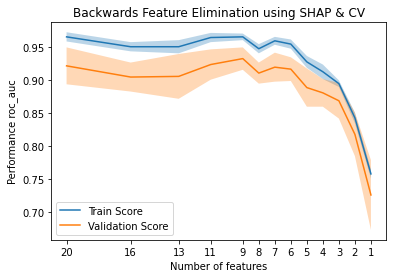

In [12]:
# Make plots
performance_plot = shap_elimination.plot()

# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=9)

As it is hinted in the example above, with large datasets and simple base learners, early stopping can be a much faster alternative to hyperparameter optimization of the ideal number of trees.

Note that although `EarlyStoppingShapRFECV` supports hyperparameter search models as input, early stopping is used only during the Shapley value estimation step, and not during hyperparameter search. For this reason, _if you are not using early stopping, you should use the parent class, `ShapRFECV`, instead of `EarlyStoppingShapRFECV`_.